# Visão Computacional e Deep Learning para Sensoriamento Remoto com Python


# Capítulo 13 - Arquiteturas Avançadas de Segmentação Semântica - Parte 2

##DeepLabV3+

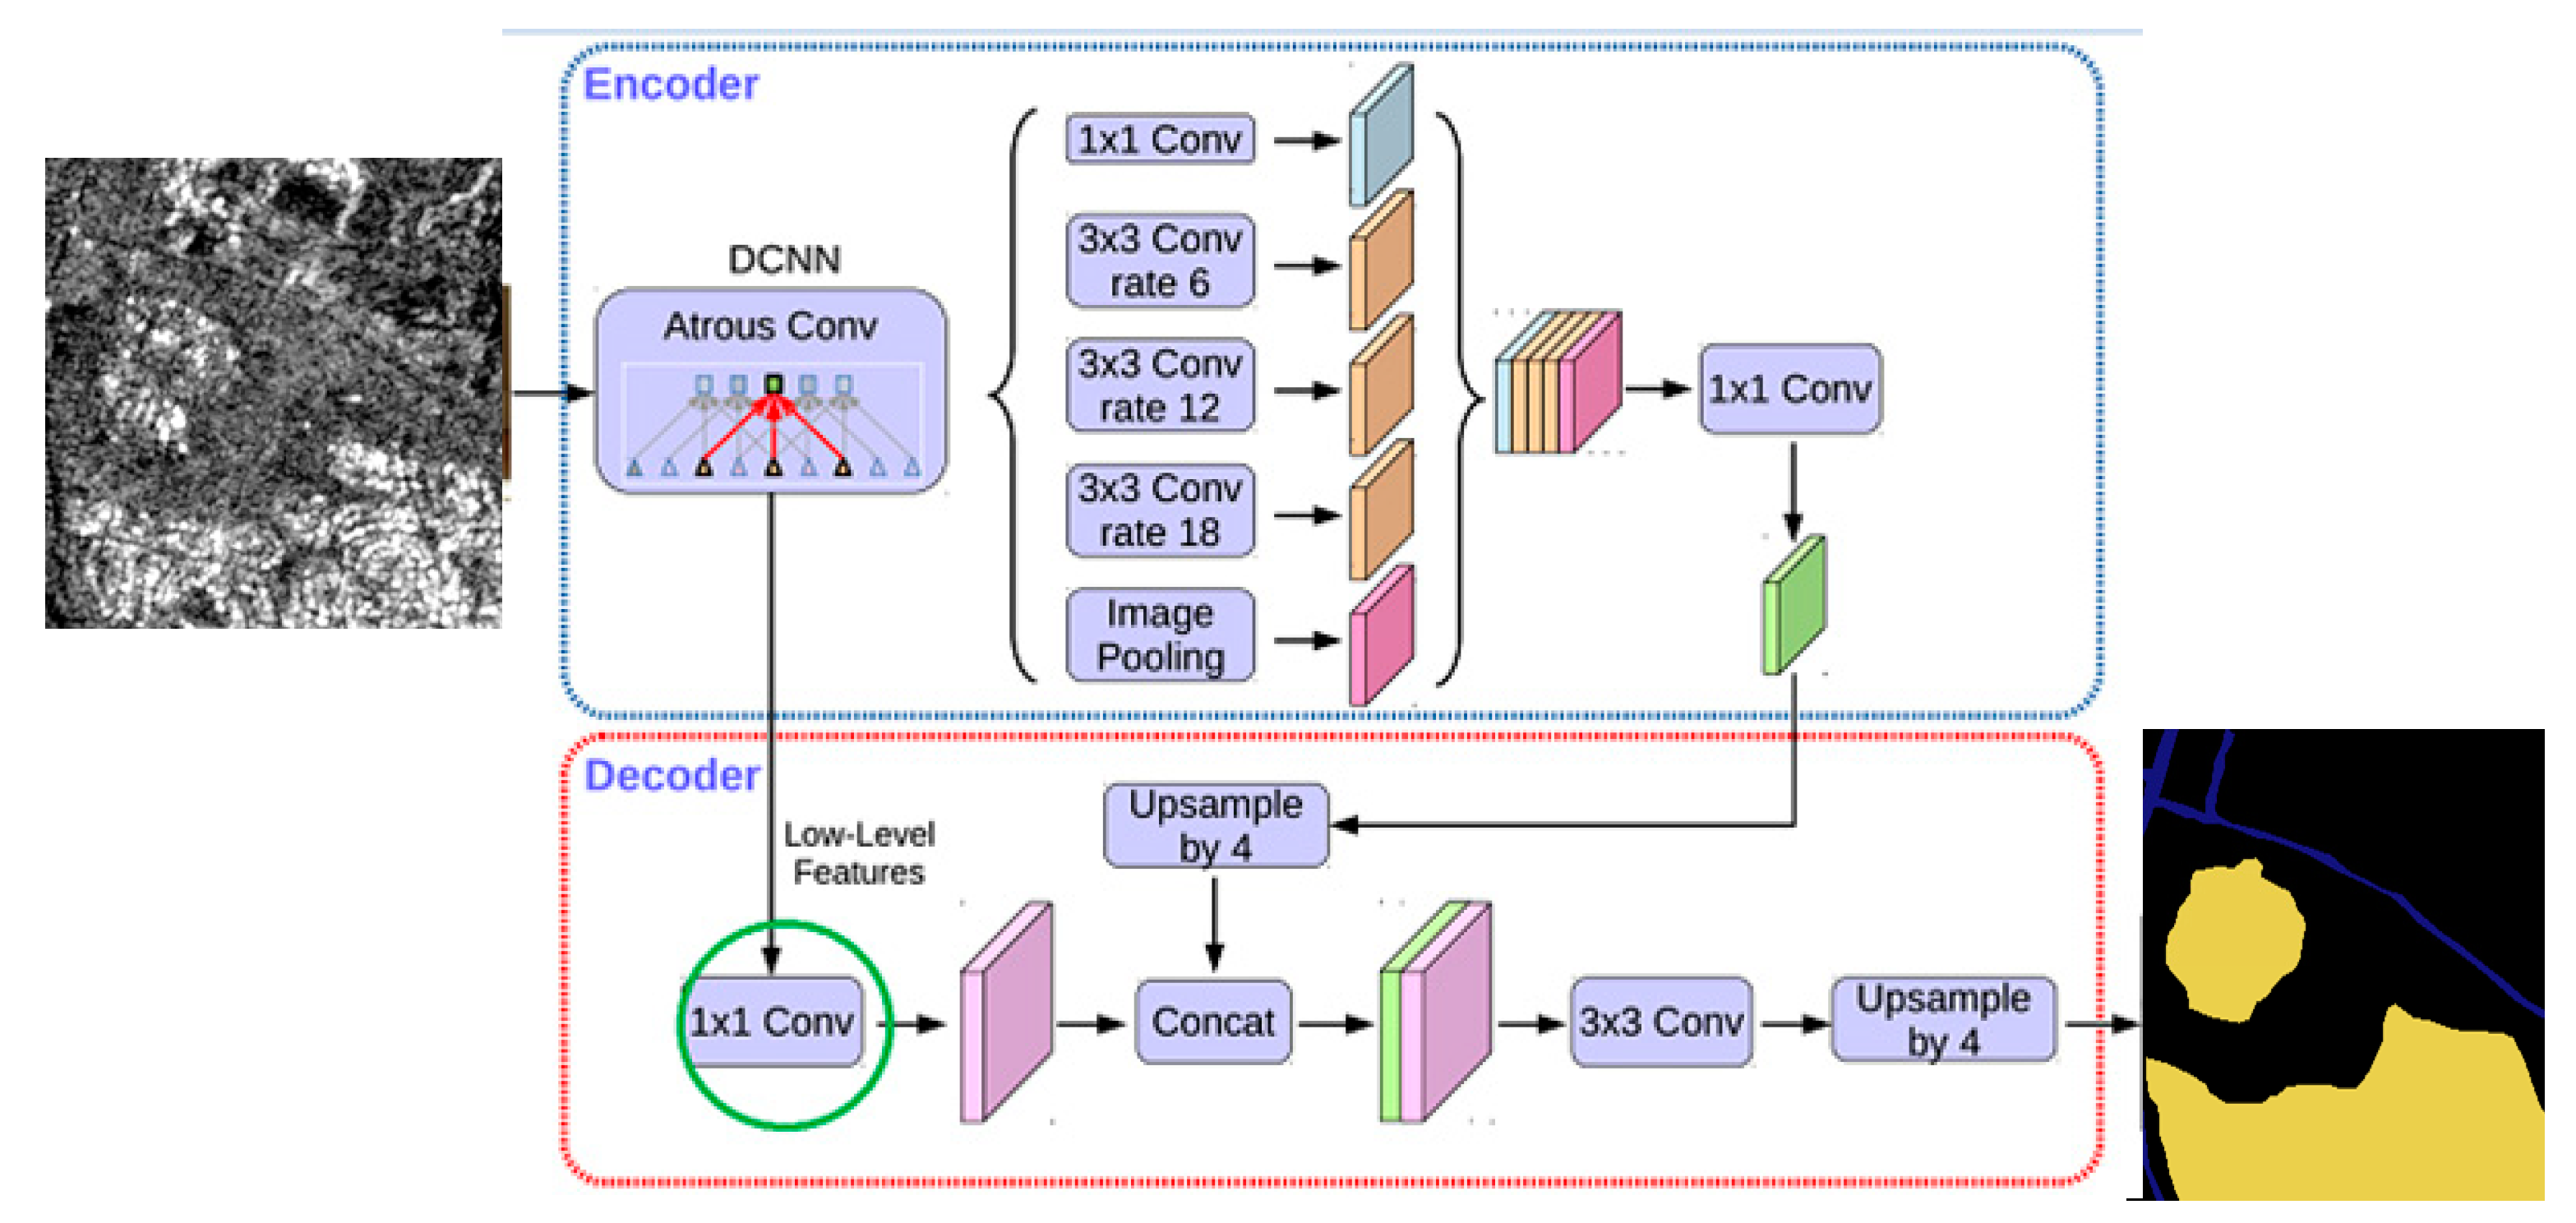

O DeepLabv3+ estende o DeepLabv3 adicionando uma estrutura de codificador-decodificador. O módulo codificador processa informações contextuais multiescala aplicando convolução dilatada em escalas múltiplas, enquanto o módulo decodificador refina os resultados da segmentação ao longo dos limites do objeto.

Convolução dilatada: Com a convolução dilatada, à medida que nos aprofundamos na rede, podemos manter o passo constante, mas com um campo de visão maior sem aumentar o número de parâmetros ou a quantidade de computação. Além disso, permite mapas de recursos de saída maiores, o que é útil para segmentação semântica.

A razão para usar o Dilated Spatial Pyramid Pooling é que foi mostrado que, à medida que a taxa de amostragem aumenta, o número de pesos de filtro válidos (ou seja, pesos aplicados à região de recurso válido, em vez de zeros preenchidos) torna-se menor.

O downsampling múltiplo de uma CNN levará a resolução do mapa de recursos a se tornar menor, resultando em menor precisão de previsão e perda de informações de limite na segmentação semântica. Da mesma forma, agregar contexto em torno de um recurso ajuda a segmentá-lo melhor, o que é feito com as convoluções atróficas. O DeepLabv3+ ajuda a resolver esses problemas.

###Atrous rate


Atrous Convolution/Dilated Convolution é uma ferramenta para refinar o campo de visão efetivo da convolução. Ele modifica o campo de visão usando um parâmetro denominado taxa atrosa. É uma abordagem simples, porém poderosa, para ampliar o campo de visão dos filtros sem afetar a computação ou o número de parâmetros.



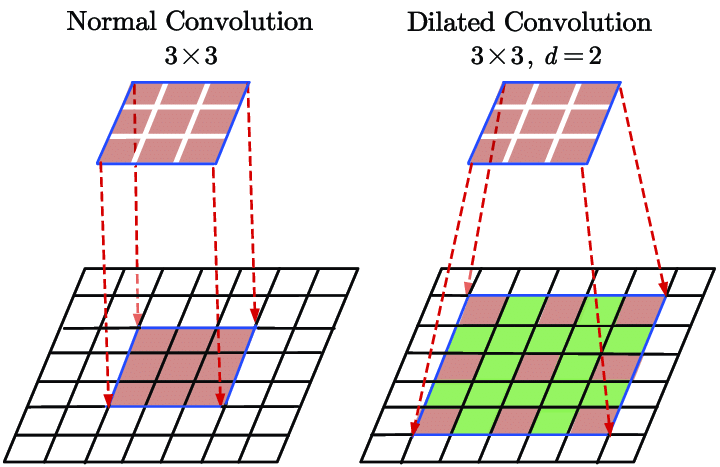

O DeepLabV3+ adiciona um codificador baseado no DeepLabV3 para corrigir o problema observado anteriormente de o DeepLabV3 consumir muito tempo para processar imagens de alta resolução.
A aplicação da convolução separável em profundidade para pooling de pirâmide espacial atrosa e módulos decodificadores resulta em uma rede de codificador-decodificador mais rápida e mais forte para segmentação semântica.

###Atrous Separable Convolution

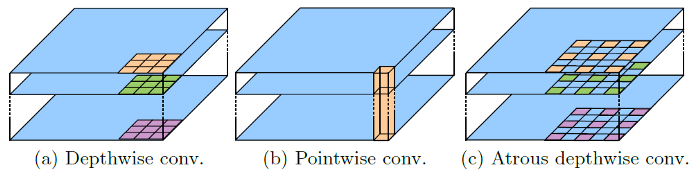

(a) e (b), Convolução Separável em Profundidade: fatora uma convolução padrão em uma convolução em profundidade seguida por uma convolução pontual (ou seja, convolução 1 × 1), reduz drasticamente a complexidade da computação.


(c) Convolução Atrosa em Profundidade: A convolução Atrosa é suportada na convolução em profundidade. E descobriu-se que reduz significativamente a complexidade de computação do modelo proposto, mantendo desempenho semelhante (ou melhor).
Combinando com a convolução pontual, é a convolução atrosa separável.

Então, vamos implementar a DeepLabV3+:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import io
import os, csv

COnfiguramos os caminhos da imagem RGB, da mascara e tabela de cores das classes.

In [ ]:
image_path = '/content/drive/MyDrive/Datasets/Cana weeds/sugarcane2.png'
mask_path = '/content/drive/MyDrive/Datasets/Cana weeds/crop6GT.png'
class_path = '/content/drive/MyDrive/Datasets/Cana weeds/class_dict.csv'

Vamos abrir e plotar a imagem e a mascara:

In [ ]:
rgb_img = io.imread(image_path)
msk_img = io.imread(mask_path)

(-0.5, 5363.5, 6814.5, -0.5)

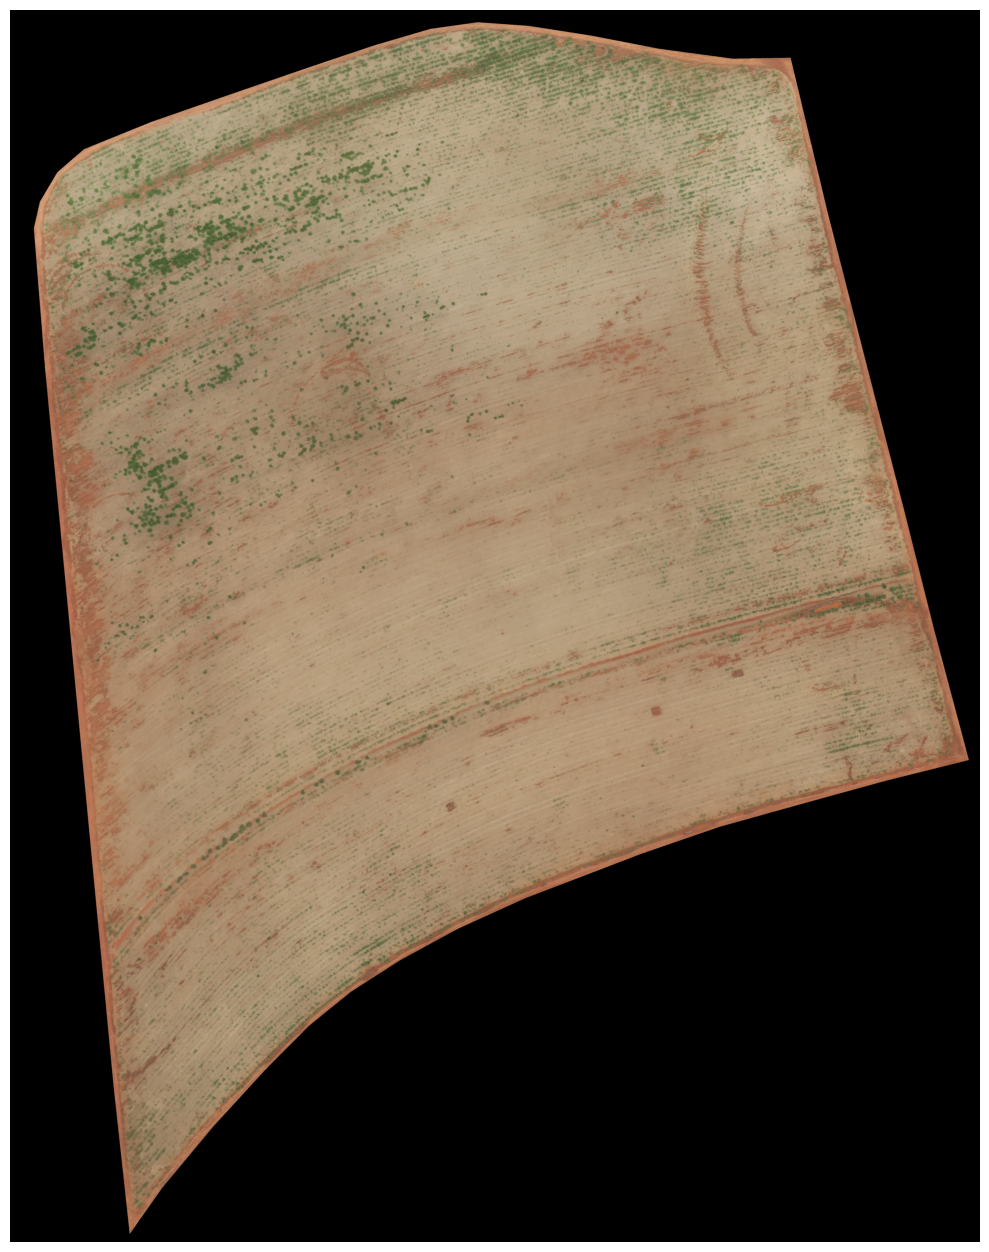

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(rgb_img)
plt.axis('off')

(-0.5, 5363.5, 6814.5, -0.5)

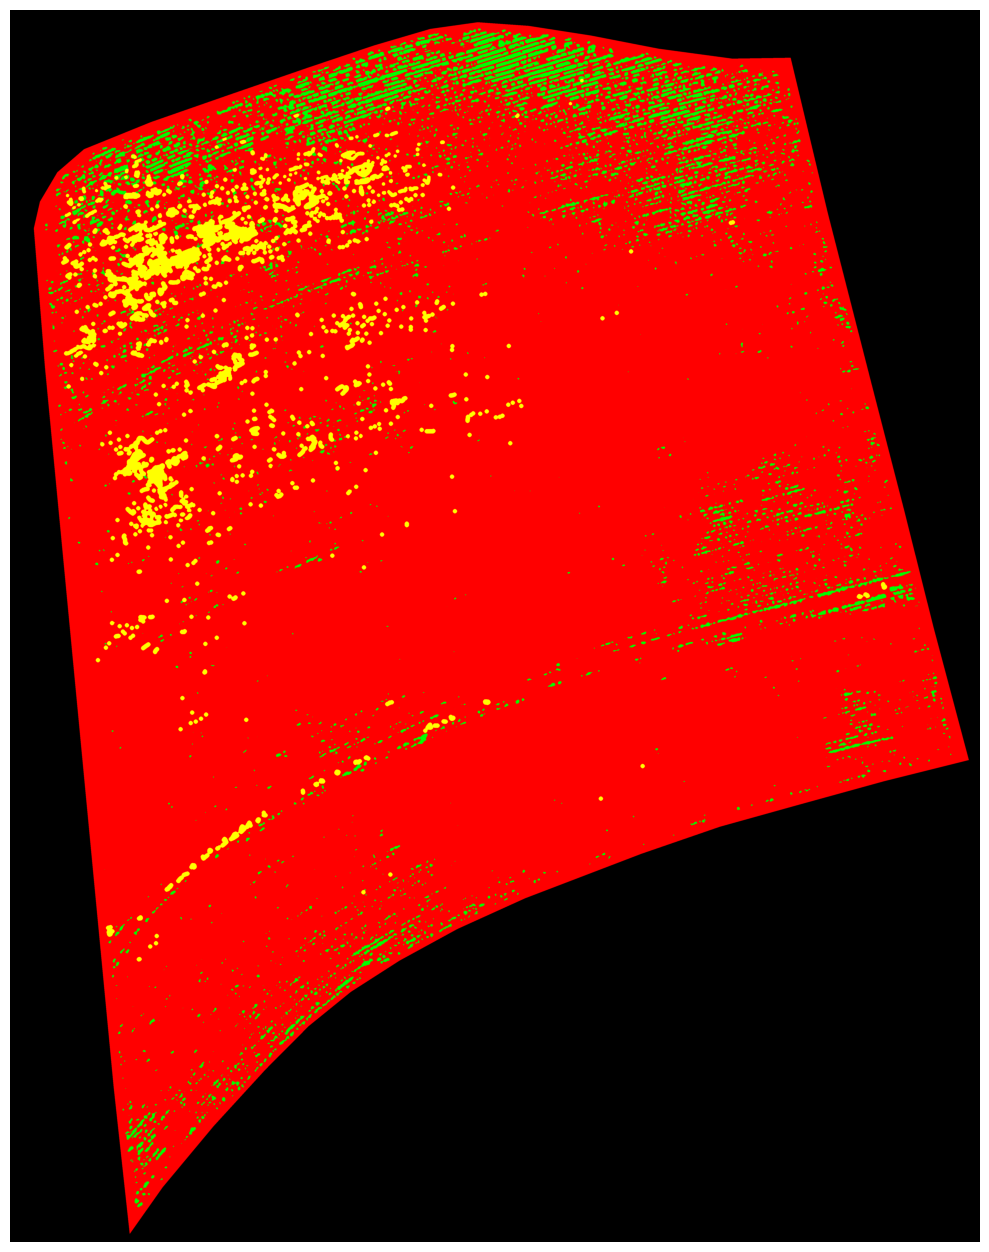

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(msk_img)
plt.axis('off')

A máscara é composta por uma imagem RGB onde cada cor representa uma classe. Precisamos categorizar e converter os valores dessas cores para uma imagem de uma banda com valores inteiros para cada classe. Para isso vamos criar algumas funções para facilitar isso:

In [ ]:
def get_label_info(csv_path):
    """
    Retrieve the class names and label values for the selected dataset.
    Must be in CSV format!

    # Arguments
        csv_path: The file path of the class dictionairy

    # Returns
        Two lists: one for the class names and the other for the label values
    """
    filename, file_extension = os.path.splitext(csv_path)
    if not file_extension == ".csv":
        return ValueError("File is not a CSV!")

    class_names = []
    label_values = []
    with open(csv_path, 'r') as csvfile:
        file_reader = csv.reader(csvfile, delimiter=',')
        header = next(file_reader)
        for row in file_reader:
            class_names.append(row[0])
            label_values.append([int(row[1]), int(row[2]), int(row[3])])
        # print(class_dict)
    return class_names, label_values



In [ ]:
def one_hot_it(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes

    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    # st = time.time()
    # w = label.shape[0]
    # h = label.shape[1]
    # num_classes = len(class_dict)
    # x = np.zeros([w,h,num_classes])
    # unique_labels = sortedlist((class_dict.values()))
    # for i in range(0, w):
    #     for j in range(0, h):
    #         index = unique_labels.index(list(label[i][j][:]))
    #         x[i,j,index]=1
    # print("Time 1 = ", time.time() - st)

    # st = time.time()
    # https://stackoverflow.com/questions/46903885/map-rgb-semantic-maps-to-one-hot-encodings-and-vice-versa-in-tensorflow
    # https://stackoverflow.com/questions/14859458/how-to-check-if-all-values-in-the-columns-of-a-numpy-matrix-are-the-same
    semantic_map = []
    for colour in label_values:
        # colour_map = np.full((label.shape[0], label.shape[1], label.shape[2]), colour, dtype=int)
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    # print("Time 2 = ", time.time() - st)

    return semantic_map

def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.

    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    # w = image.shape[0]
    # h = image.shape[1]
    # x = np.zeros([w,h,1])

    # for i in range(0, w):
    #     for j in range(0, h):
    #         index, value = max(enumerate(image[i, j, :]), key=operator.itemgetter(1))
    #         x[i, j] = index

    x = np.argmax(image, axis = -1)
    return x


def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.

    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """

    # w = image.shape[0]
    # h = image.shape[1]
    # x = np.zeros([w,h,3])
    # colour_codes = label_values
    # for i in range(0, w):
    #     for j in range(0, h):
    #         x[i, j, :] = colour_codes[int(image[i, j])]

    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

Vamos obter as classes que temos e o mapeamento de valores das classes da mascara:

In [ ]:
class_names_list, label_values = get_label_info(class_path)
class_names_string = ""
for class_name in class_names_list:
    if not class_name == class_names_list[-1]:
        class_names_string = class_names_string + class_name + ", "
    else:
        class_names_string = class_names_string + class_name

In [ ]:
class_names_list

['Invalid_area', 'SugarCane', 'Soil', 'Invasive']

In [ ]:
label_values

[[0, 0, 0], [0, 255, 0], [255, 0, 0], [255, 255, 0]]

Então convertemos a mascara e 3 canais para 1:

In [ ]:
gt = reverse_one_hot(one_hot_it(msk_img, label_values))

In [ ]:
np.unique(gt)

array([0, 1, 2, 3])

In [ ]:
gt.shape

(6815, 5364)

(-0.5, 5363.5, 6814.5, -0.5)

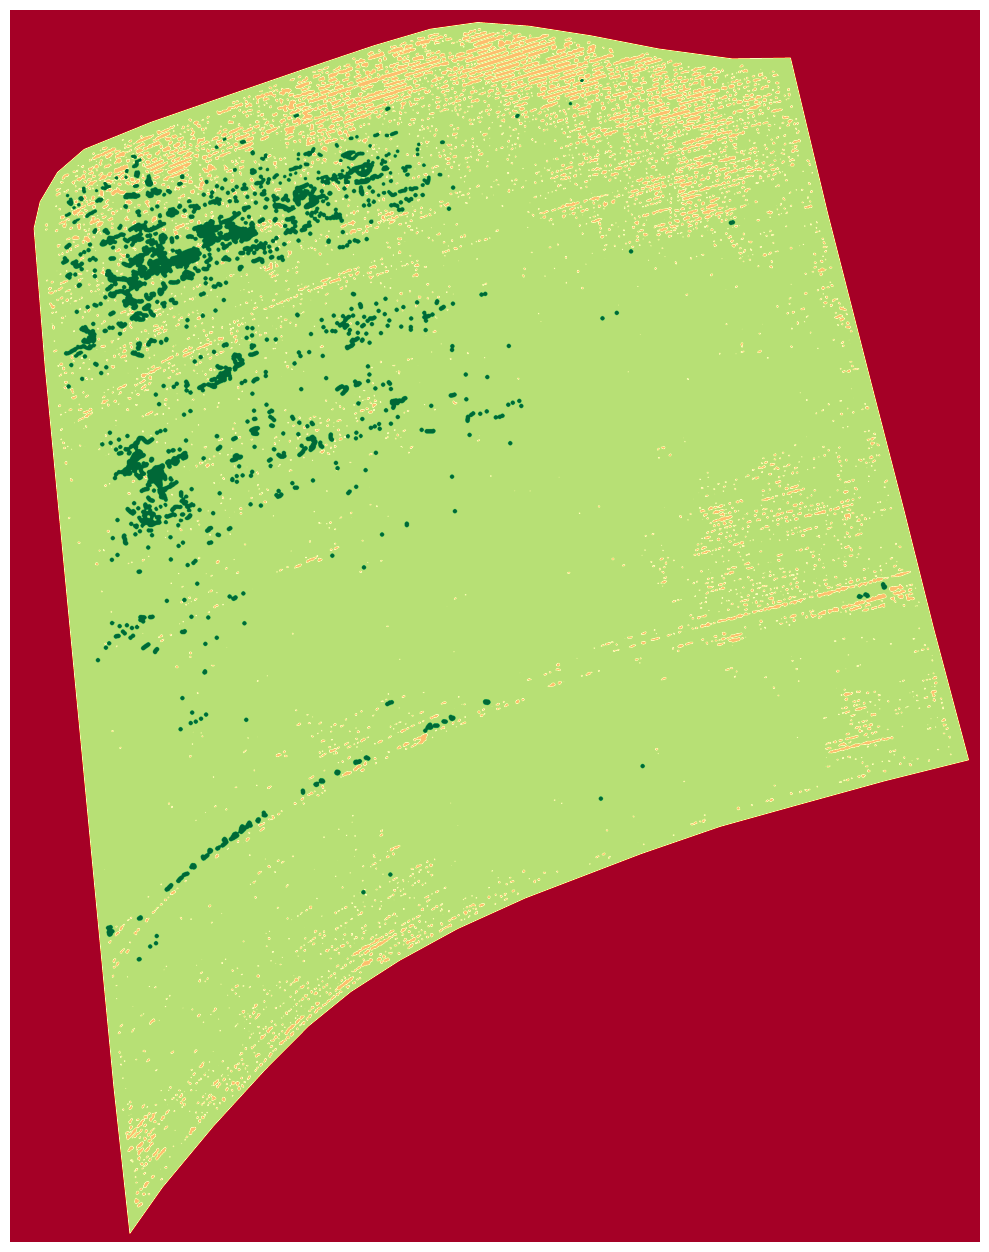

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(gt, cmap='RdYlGn')
plt.axis('off')

In [ ]:
gt

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Agora vamos dividir a imagem RGB e a mascara em patches de 256x256:

In [ ]:
from os import mkdir

In [ ]:
mkdir('output')

In [ ]:
OUTPUT_DIR = "/content/output"
TARGET_SIZE = 256

In [ ]:
k = 0
for y in range(0, rgb_img.shape[0], TARGET_SIZE):
    for x in range(0, rgb_img.shape[1], TARGET_SIZE):
        img_tile = rgb_img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
        mask_tile = gt[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

        if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
          if not (mask_tile.mean() == 0 or mask_tile.mean() == 2) :
            out_img_path = os.path.join(OUTPUT_DIR, "img_{}.png".format(k))
            io.imsave(out_img_path, img_tile)

            out_mask_path = os.path.join(OUTPUT_DIR, "msk_{}.png".format(k))
            cv2.imwrite(out_mask_path, mask_tile)
            k += 1

<ipython-input-20-6884110b15b1>:10: UserWarning: /content/output/img_8.png is a low contrast image
  io.imsave(out_img_path, img_tile)
<ipython-input-20-6884110b15b1>:10: UserWarning: /content/output/img_142.png is a low contrast image
  io.imsave(out_img_path, img_tile)
<ipython-input-20-6884110b15b1>:10: UserWarning: /content/output/img_163.png is a low contrast image
  io.imsave(out_img_path, img_tile)
<ipython-input-20-6884110b15b1>:10: UserWarning: /content/output/img_175.png is a low contrast image
  io.imsave(out_img_path, img_tile)


Agora vamos criar a variável X para receber os patches RGB e Y para os patches da mascara.

In [ ]:
list_img = [f for f in os.listdir(OUTPUT_DIR) if f.startswith('img')]
list_msk = [f for f in os.listdir(OUTPUT_DIR) if f.startswith('msk')]

In [ ]:
list_img.sort()
list_msk.sort()

In [ ]:
X = []
for path_img in list_img:
  full_path = os.path.join(OUTPUT_DIR, path_img)
  img = io.imread(full_path)
  X.append(img)

In [ ]:
Y = []
for path_msk in list_msk:
  full_path = os.path.join(OUTPUT_DIR, path_msk)
  msk = io.imread(full_path)
  Y.append(msk)

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X.shape

(342, 256, 256, 4)

Vamos visualizar os dados:

(-0.5, 255.5, 255.5, -0.5)

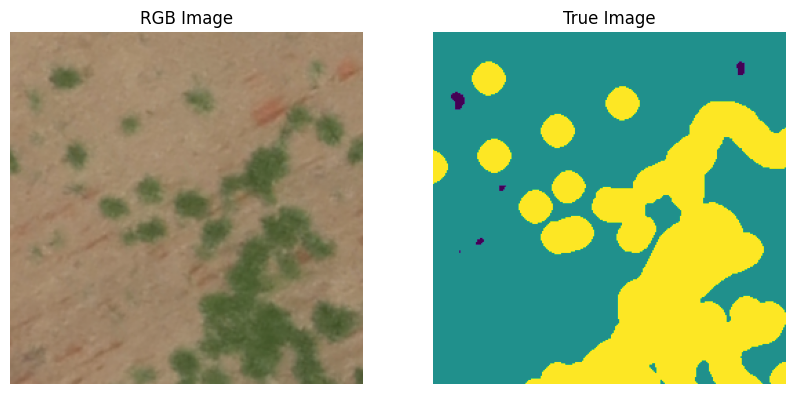

In [ ]:
i = 54
plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(X[i,:,:,:])
plt.title('RGB Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(Y[i,:,:])
plt.title('True Image')
plt.axis('off')

Vamos aplicar o one hot encoder nos labels:

In [ ]:
from keras.utils import np_utils
from keras.models import Model
from keras.regularizers import l2
from keras.layers import *
from keras.models import *
import keras.backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
Y = np_utils.to_categorical(Y,len(class_names_list))

In [ ]:
Y.shape

(342, 256, 256, 4)

Aqui faremos a divisão do dataset em treinamento e teste:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [ ]:
x_train = x_train/255
x_test = x_test/255

In [ ]:
y_train = y_train.astype('float')
y_test = y_test.astype('float')

Criamos a função de loss a ser usada na rede:

In [ ]:
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)


Implementamos o aumento de dados:

In [ ]:
img_datagen = ImageDataGenerator(
    rotation_range=90,
    vertical_flip = True,
    horizontal_flip=True)

mask_datagen = ImageDataGenerator(
    rotation_range=90,
    vertical_flip = True,
    horizontal_flip=True)

In [ ]:
img_datagen.fit(x_train, augment=True,seed=1200)
mask_datagen.fit(y_train, augment=True,seed=1200)

In [ ]:
X=img_datagen.flow(x_train,batch_size=8,seed=1200)
Y=mask_datagen.flow(y_train,batch_size=8,seed=1200)

In [ ]:
train_generator = zip(X, Y)

In [ ]:
len(x_test)/8

12.875

In [ ]:
steps_per_epoch = len(x_train)//8
validation_steps = len(x_test)//8

E então podemos construir a DeepLabV3+:

In [ ]:
from keras import backend as K
from keras.layers import Layer
import tensorflow as tf

def SepConv_BN(x, filters, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),padding=depth_padding, use_bias=False)(x)
    x = BatchNormalization(epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization(epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    return x


def _conv2d_same(x, filters, stride=1, kernel_size=3, rate=1):
    if stride == 1:
        return Conv2D(filters,(kernel_size, kernel_size),strides=(stride, stride),padding='same',use_bias=False,dilation_rate=(rate, rate))(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,(kernel_size, kernel_size),strides=(stride, stride),padding='valid',use_bias=False,dilation_rate=(rate, rate))(x)


def _xception_block(inputs, depth_list, skip_connection_type, stride, rate=1, depth_activation=False, return_skip=False):
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,depth_list[i],stride=stride if i == 2 else 1,rate=rate,depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1],kernel_size=1,stride=stride)
        shortcut = BatchNormalization()(shortcut)
        outputs = add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def relu6(x):
    return relu(x, max_value=6)


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1].value
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    if block_id:
        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',use_bias=False, activation=None)(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999)(x)
        x = Activation(relu6)(x)
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,use_bias=False, padding='same', dilation_rate=(rate, rate))(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999)(x)
    x = Activation(relu6)(x)

    # Project
    x = Conv2D(pointwise_filters, kernel_size=1, padding='same', use_bias=False, activation=None)(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999)(x)
    if skip_connection:
        return Add()([inputs, x])
    return x

In [ ]:
inputs = Input(shape=x_train.shape[1:])
backbone = 'xception'
n_classe = 4

if backbone == 'xception':
    entry_block3_stride = 2
    middle_block_rate = 1
    exit_block_rates = (1, 2)
    atrous_rates = (6, 12, 18)

    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = _conv2d_same(x, 64, kernel_size=3, stride=1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = _xception_block(x, [128, 128, 128], skip_connection_type='conv', stride=2, depth_activation=False)
    x, skip1 = _xception_block(x, [256, 256, 256], skip_connection_type='conv', stride=2, depth_activation=False, return_skip=True)

    x = _xception_block(x, [512, 512, 512],skip_connection_type='conv', stride=entry_block3_stride, depth_activation=False)
    for i in range(16):
        x = _xception_block(x, [512, 512, 512], skip_connection_type='sum', stride=1, rate=middle_block_rate, depth_activation=False)

    x = _xception_block(x, [512, 1024, 1024], skip_connection_type='conv', stride=1, rate=exit_block_rates[0], depth_activation=False)
    x = _xception_block(x, [1024, 1024, 2048], skip_connection_type='none', stride=1, rate=exit_block_rates[1], depth_activation=True)

else:
    OS = 8
    alpha = 1
    first_block_filters = _make_divisible(32 * alpha, 8)
    x = Conv2D(first_block_filters, kernel_size=3, strides=(2, 2), padding='same', use_bias=False)(inputs)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999)(x)
    x = Activation(relu6)(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0, skip_connection=False)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2, expansion=6, block_id=1, skip_connection=False)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2, skip_connection=True)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3, skip_connection=False)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4, skip_connection=True)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5, skip_connection=True)

          # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=6, skip_connection=False)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2, expansion=6, block_id=7, skip_connection=True)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2, expansion=6, block_id=8, skip_connection=True)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2, expansion=6, block_id=9, skip_connection=True)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2, expansion=6, block_id=10, skip_connection=False)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2, expansion=6, block_id=11, skip_connection=True)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2, expansion=6, block_id=12, skip_connection=True)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2, expansion=6, block_id=13, skip_connection=False)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4, expansion=6, block_id=14, skip_connection=True)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4, expansion=6, block_id=15, skip_connection=True)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4, expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

shape_before = tf.shape(x)
b4 = GlobalAveragePooling2D()(x)

b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
b4 = Conv2D(256, (1, 1), padding='same', use_bias=False)(b4)
b4 = BatchNormalization(epsilon=1e-5)(b4)
b4 = Activation('relu')(b4)

size_before = tf.keras.backend.int_shape(x)
b4 = Lambda(lambda x: tf.compat.v1.image.resize(x, size_before[1:3],method='bilinear', align_corners=True))(b4)
    # simple 1x1
b0 = Conv2D(256, (1, 1), padding='same', use_bias=False)(x)
b0 = BatchNormalization(epsilon=1e-5)(b0)
b0 = Activation('relu')(b0)

if backbone == 'xception':
        # rate = 6 (12)
    b1 = SepConv_BN(x, 256, rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
    b2 = SepConv_BN(x, 256, rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
    b3 = SepConv_BN(x, 256, rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
    x = Concatenate()([b4, b0, b1, b2, b3])
else:
    x = Concatenate()([b4, b0])

x = Conv2D(256, (1, 1), padding='same', use_bias=False)(x)
x = BatchNormalization(epsilon=1e-5)(x)
x = Activation('relu')(x)
x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

if backbone == 'xception':
    size_before2 = tf.keras.backend.int_shape(x)
    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx, skip1.shape[1:3], method='bilinear', align_corners=True))(x)
    #x = Conv2DTranspose(48, (3, 3), strides=(4, 4), kernel_initializer='he_uniform', padding='same')(x)

    dec_skip1 = Conv2D(48, (1, 1), padding='same', use_bias=False)(skip1)
    dec_skip1 = BatchNormalization(epsilon=1e-5)(dec_skip1)
    dec_skip1 = Activation('relu')(dec_skip1)
    x = Concatenate()([x, dec_skip1])
    x = SepConv_BN(x, 256, depth_activation=True, epsilon=1e-5)
    x = SepConv_BN(x, 256, depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes

#x = Conv2DTranspose(32, (3, 3), strides=(4, 4), kernel_initializer='he_uniform', padding='same')(x)
x = Conv2D(n_classe, (1, 1), padding='same')(x)
size_before3 = tf.keras.backend.int_shape(inputs)
x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,size_before3[1:3],method='bilinear', align_corners=True))(x)
x = Activation('softmax')(x)

model = Model(inputs, x)
model.compile(optimizer=Adam(lr = 1e-5,decay=1e-6), loss = focal_tversky, metrics='accuracy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 128, 128, 32  1152        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_39 (BatchN  (None, 128, 128, 32  128        ['conv2d_22[0][0]']              
 ormalization)                  )                                                             

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 ormalization)                                                                                    
                                                                                                  
 conv2d_32 (Conv2D)             (None, 32, 32, 512)  131072      ['batch_normalization_55[0][0]'] 
                                                                                                  
 batch_normalization_56 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_28 (Activation)     (None, 32, 32, 512)  0           ['batch_normalization_56[0][0]'] 
                                                                                                  
 depthwise_conv2d_24 (Depthwise  (None, 32, 32, 512)  4608       ['activation_28[0][0]']          
 Conv2D)  

In [ ]:
history = model.fit_generator(train_generator,steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
                              epochs=300, validation_data=(x_test,y_test))

<ipython-input-54-f0bb3fd73806>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,


Epoch 1/100
29/29 [==============================] - 9s 308ms/step - loss: 0.1715 - accuracy: 0.9083 - val_loss: 0.1508 - val_accuracy: 0.9212
Epoch 2/100
29/29 [==============================] - 8s 289ms/step - loss: 0.1585 - accuracy: 0.9173 - val_loss: 0.1566 - val_accuracy: 0.9172
Epoch 3/100
29/29 [==============================] - 8s 285ms/step - loss: 0.1623 - accuracy: 0.9129 - val_loss: 0.1493 - val_accuracy: 0.9220
Epoch 4/100
29/29 [==============================] - 8s 291ms/step - loss: 0.1745 - accuracy: 0.9050 - val_loss: 0.1654 - val_accuracy: 0.9112
Epoch 5/100
29/29 [==============================] - 8s 284ms/step - loss: 0.1725 - accuracy: 0.9067 - val_loss: 0.1464 - val_accuracy: 0.9240
Epoch 6/100
29/29 [==============================] - 8s 286ms/step - loss: 0.1574 - accuracy: 0.9173 - val_loss: 0.1612 - val_accuracy: 0.9140
Epoch 7/100
29/29 [==============================] - 8s 287ms/step - loss: 0.1710 - accuracy: 0.9073 - val_loss: 0.1506 - val_accuracy: 0.9206

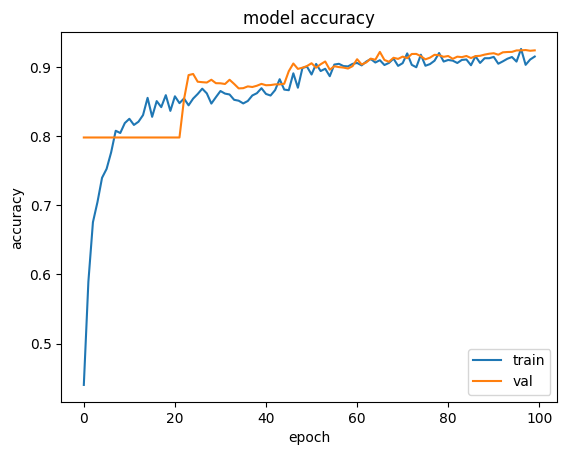

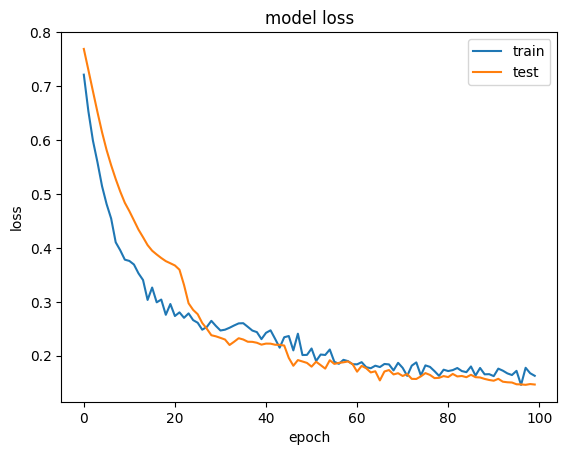

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Após o treinamento, vamos obter algumas métricas de validação:

In [ ]:
from keras.models import model_from_json
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score

Começamos calculando a precisão para o conjunto de teste:

In [ ]:
predict = model.predict(x_test)

4/4 [==============================] - 0s 108ms/step


In [ ]:
predict = np.round(predict)

In [ ]:
pred = np.argmax(predict, axis=3)

In [ ]:
true = np.argmax(y_test, axis=3)

Acurácia:

In [ ]:
accuracy = accuracy_score(true.flatten(),pred.flatten())
print(accuracy)

0.9479219010732707


F1 Score:

In [ ]:
f1_score(true.flatten(), pred.flatten(), average='macro')

0.7527458780899748

In [ ]:
f1_score(true.flatten(), pred.flatten(), average='micro')

0.9479219010732707

In [ ]:
f1_score(true.flatten(), pred.flatten(), average='weighted')

0.9395697605269571

Recall:

In [ ]:
recall_score(true.flatten(), pred.flatten(), average='macro')

0.7117527073740617

Kappa

In [ ]:
cohen_kappa_score(true.flatten(), pred.flatten())

0.8385617288552756

Matrix confusão:

In [ ]:
cm = confusion_matrix(true.flatten(), pred.flatten())
print(cm)

[[ 875568       0     381     175]
 [   9519   86870  161540   32956]
 [  28130   21241 5326131   11174]
 [   5044     107   81271  110101]]


Text(0.5, 58.5815972222222, 'Predito')

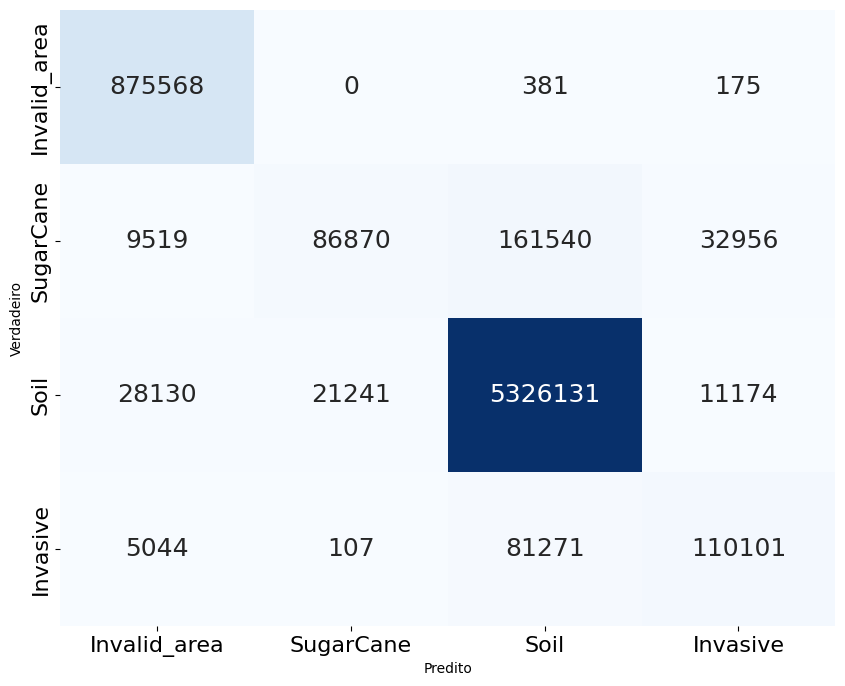

In [ ]:
columns = class_names_list
r1 = pd.DataFrame(data=cm, columns=columns, index=columns)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(r1, annot=True, annot_kws={"size": 18},fmt='d',cmap="Blues", cbar = False)
#for t in ax.texts: t.set_text(t.get_text() + " %")
ax.tick_params(labelsize=16)
ax.set_ylabel('Verdadeiro')
ax.set_xlabel('Predito')

Por fim, vamos traçar um exemplo do resultado previsto em comparação com a máscara original:

(-0.5, 255.5, 255.5, -0.5)

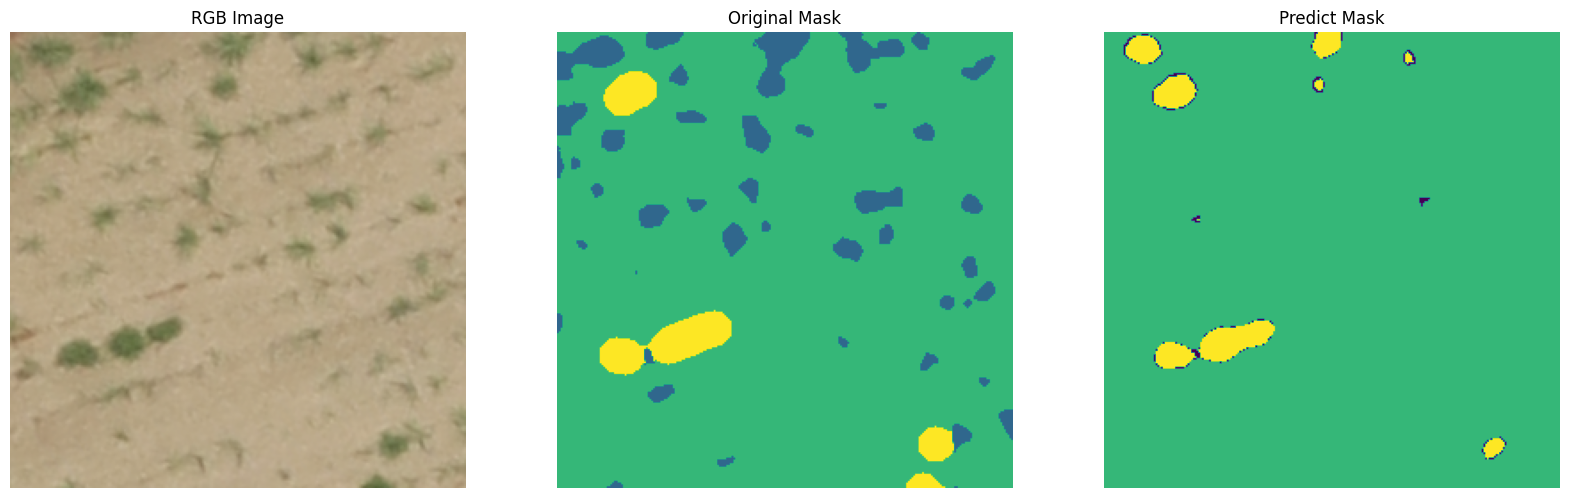

In [ ]:
i = 10
plt.figure(figsize=[20,8])
plt.subplot(131)
plt.imshow(x_test[i])
plt.title('RGB Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(true[i], vmin=0,vmax=3)
plt.title('Original Mask')
plt.axis('off')
plt.subplot(133)
plt.imshow(pred[i], vmin=0,vmax=3)
plt.title('Predict Mask')
plt.axis('off')


Também podemos salvar a arquitetura e os pesos treinados:

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/Datasets/Cana weeds/Deeplabv3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/Datasets/Cana weeds/Model300.h5")